# MINE4201- SR -  Taller 2
## Modelos colaborativos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuración inicial

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162986 sha256=e76b0b1718afda6277e5e785851c30457bdd17fd19a12ec504b305aad8e433d7
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [5]:
!tar -xzvf '/content/drive/MyDrive/Colab files/taller2_recomendacion/yelp_dataset.tar'

Dataset_User_Agreement.pdf
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json


## Exploración de datos

### Tabla de interacciones


Modificamos los nombres de las columnas

In [ ]:
path = os.path.join('lastfm-dataset-1K', 'userid-timestamp-artid-artname-traid-traname.tsv')

columns = ['user-id', 'timestamp', 'artist-id', 'artist-name', 'track-id', 'track-name']

# cargamos la columna de de timestamp con formato de fecha
df = pd.read_csv(path, sep='\t', error_bad_lines=False, header=None,
                 names=columns, parse_dates = ['timestamp'])

<ipython-input-5-c311c5699929>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(path, sep='\t', error_bad_lines=False, header=None,
Skipping line 2120260: expected 6 fields, saw 8

Skipping line 2446318: expected 6 fields, saw 8

Skipping line 11141081: expected 6 fields, saw 8

Skipping line 11152099: expected 6 fields, saw 12
Skipping line 11152402: expected 6 fields, saw 8

Skipping line 11882087: expected 6 fields, saw 8

Skipping line 12902539: expected 6 fields, saw 8
Skipping line 12935044: expected 6 fields, saw 8

Skipping line 17589539: expected 6 fields, saw 8



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19098853 entries, 0 to 19098852
Data columns (total 6 columns):
 #   Column       Dtype              
---  ------       -----              
 0   user-id      object             
 1   timestamp    datetime64[ns, UTC]
 2   artist-id    object             
 3   artist-name  object             
 4   track-id     object             
 5   track-name   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 874.3+ MB


In [ ]:
df.head()

,user-id,timestamp,artist-id,artist-name,track-id,track-name
0,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [ ]:
df['timestamp'].sort_values()

7558602    2005-02-14 00:00:07+00:00
16881008   2005-02-14 00:00:38+00:00
13492623   2005-02-14 00:01:44+00:00
5577100    2005-02-14 00:02:10+00:00
2859032    2005-02-14 00:02:40+00:00
                      ...           
18453011   2009-06-19 21:23:17+00:00
18453010   2009-06-19 21:27:08+00:00
12032168   2009-06-19 21:31:16+00:00
7696484    2010-08-13 23:06:38+00:00
14293405   2013-09-29 18:32:04+00:00
Name: timestamp, Length: 19098853, dtype: datetime64[ns, UTC]

### Tabla de usuarios

In [ ]:
path_user = os.path.join('lastfm-dataset-1K', 'userid-profile.tsv')

df_user = pd.read_csv(path_user, sep='\t')
df_user.info()
df_user.country.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   #id         992 non-null    object 
 1   gender      884 non-null    object 
 2   age         286 non-null    float64
 3   country     907 non-null    object 
 4   registered  984 non-null    object 
dtypes: float64(1), object(4)
memory usage: 38.9+ KB


array(['Japan', 'Peru', 'United States', nan, 'Bulgaria',
       'Russian Federation', 'Slovakia', 'Poland', 'Finland', 'Romania',
       "Cote D'Ivoire", 'United Kingdom', 'Morocco', 'Mexico', 'Germany',
       'Canada', 'Sweden', 'Turkey', 'Italy', 'Brazil', 'Australia',
       'Chile', 'Greece', 'Croatia', 'Serbia', 'Netherlands', 'Armenia',
       'Venezuela', 'New Zealand', 'Norway', 'Latvia', 'Spain', 'Estonia',
       'United States Minor Outlying Islands', 'Czech Republic',
       'Antarctica', 'Trinidad and Tobago', 'Portugal', 'Switzerland',
       'Nicaragua', 'Ireland', 'Belgium',
       "Korea, Democratic People's Republic of",
       'Congo, the Democratic Republic of the', 'Argentina', 'France',
       'British Indian Ocean Territory', 'Hungary', 'Thailand',
       'Macedonia', 'Slovenia', 'Algeria', 'Singapore', 'Zimbabwe',
       'China', 'Malta', 'Austria', 'Netherlands Antilles', 'Israel',
       'Colombia', 'Belarus', 'India', 'Tunisia', 'Lithuania', 'Iceland',
    

In [ ]:
selected_countries = ['Colombia', 'Venezuela', 'Peru', 'Chile', 'Argentina']

In [ ]:
selected_users = df_user[df_user['country'].isin(selected_countries)]['#id']
selected_users

print(f'Los usuarios seleccionados son el {round(len(selected_users)/len(df_user)*100,2)}% del total de usuarios y será nuestro mercado objetivo de negocio')

Los usuarios seleccionados son el 3.12% del total de usuarios y será nuestro mercado objetivo de negocio


Decisión: Filtraremos solo por usuarios latinos de los países de "Colombia" y "Venezuela" porque se alinea con nuestros objetivos del negocio

In [ ]:
aaaa

## Limpieza y filtrado de datos

Decisión 1: Nos quedamos solo con los registros para el año 2009 a partir de los cuales construiremos el sistema. Esto por diferentes razones: hay suficientes datos para entrenar un modelo (aproximadamente 2.5 M) y para el objetivo de nuestro negocio, es suficiente este año.

In [ ]:
# Filtrar las filas para el año 2008
# 2005 1M
# 2006 4M
# 2007 5M
# 2008 6M
# 2009 2.5M

df = df[df['timestamp'].dt.year == 2008]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5917696 entries, 4127 to 19098852
Data columns (total 6 columns):
 #   Column       Dtype              
---  ------       -----              
 0   user-id      object             
 1   timestamp    datetime64[ns, UTC]
 2   artist-id    object             
 3   artist-name  object             
 4   track-id     object             
 5   track-name   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 316.0+ MB


In [ ]:
df.head()

,user-id,timestamp,artist-id,artist-name,track-id,track-name
4127,user_000001,2008-12-31 16:53:59+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,bd915801-db41-4b75-9b0a-94c34d1fa387,Trains And Winter Rains
4128,user_000001,2008-12-31 16:50:19+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,NaN,O Come O Come Emmanuel [Album]/Album
4129,user_000001,2008-12-31 16:47:19+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,307307e5-aa4a-4de4-a96e-5a260fb3bb80,White Is In The Winter Night
4130,user_000001,2008-12-31 16:42:32+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,14f3f3b8-5750-4343-ab9b-30de8ed78ebb,Journey Of The Angels
4131,user_000001,2008-12-31 16:39:16+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,NaN,And Winter Came [Album]/Album


Identificamos la cantidad de NaN en las columnas

In [ ]:
df.isna().sum()

user-id             0
timestamp           0
artist-id      196095
artist-name         0
track-id       686202
track-name          0
dtype: int64

Tomamos la decisión de eliminar las fila cuyo artist-id es NaN, puesto que solo representan alreadedor del 3% de las interacciones.

In [ ]:
df = df.dropna(subset=['artist-id'])

In [ ]:
df.isna().sum()

user-id             0
timestamp           0
artist-id           0
artist-name         0
track-id       490107
track-name          0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5721601 entries, 4127 to 19098852
Data columns (total 6 columns):
 #   Column       Dtype              
---  ------       -----              
 0   user-id      object             
 1   timestamp    datetime64[ns, UTC]
 2   artist-id    object             
 3   artist-name  object             
 4   track-id     object             
 5   track-name   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 305.6+ MB


Para el caso de los track-id() con NaN, generamos un hash teniendo en cuenta el artist-id y el track-name que identifique la canción.

In [ ]:
import hashlib

# Función para generar un hash único basado en el nombre de la pista y el id del artista
def generate_unique_id(track_name, artist_id):
    # Convertir a string y codificar para generar un hash
    unique_str = str(track_name) + str(artist_id)
    unique_hash = hashlib.sha256(unique_str.encode()).hexdigest()
    # Podrías acortar el hash si deseas un identificador más corto
    return unique_hash[:16]

# Rellenar NaN en la columna 'track-id' utilizando las columnas 'track-name' y 'artist-id'
df['track-id'] = df.apply(lambda row: generate_unique_id(row['track-name'], row['artist-id']) if pd.isna(row['track-id']) else row['track-id'], axis=1)

In [ ]:
import uuid

# Función para generar un UUID único
def generate_unique_id(track_name, artist_id):
    # No necesitamos combinar el nombre de la pista y el id del artista para generar un UUID
    return str(uuid.uuid4())

# Suponiendo que 'df' es un DataFrame de pandas y tienes las columnas 'track-name', 'artist-id', y 'track-id'
# Rellenar NaN en la columna 'track-id' utilizando la función generate_unique_id
df['track-id'] = df.apply(lambda row: generate_unique_id(row['track-name'], row['artist-id']) if pd.isna(row['track-id']) else row['track-id'], axis=1)

In [ ]:
df.head()

,user-id,timestamp,artist-id,artist-name,track-id,track-name
4127,user_000001,2008-12-31 16:53:59+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,bd915801-db41-4b75-9b0a-94c34d1fa387,Trains And Winter Rains
4128,user_000001,2008-12-31 16:50:19+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,c948c97993787ca9,O Come O Come Emmanuel [Album]/Album
4129,user_000001,2008-12-31 16:47:19+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,307307e5-aa4a-4de4-a96e-5a260fb3bb80,White Is In The Winter Night
4130,user_000001,2008-12-31 16:42:32+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,14f3f3b8-5750-4343-ab9b-30de8ed78ebb,Journey Of The Angels
4131,user_000001,2008-12-31 16:39:16+00:00,4967c0a1-b9f3-465e-8440-4598fd9fc33c,Enya,0e42835d661524e7,And Winter Came [Album]/Album


Verificamos que ya no hayan NaNs


In [ ]:
df.isna().sum()

user-id        0
timestamp      0
artist-id      0
artist-name    0
track-id       0
track-name     0
dtype: int64

In [ ]:
user_count = df.groupby('user-id')['track-id'].agg({'count'}).sort_values(by='count', ascending=False)
user_count = user_count.reset_index()
user_count

,user-id,count
0,user_000529,70164
1,user_000791,66369
2,user_000691,58425
3,user_000544,57691
4,user_000068,49861
...,...,...
829,user_000693,1
830,user_000597,1
831,user_000386,1
832,user_000183,1


Identificamos fenómeno de cola larga

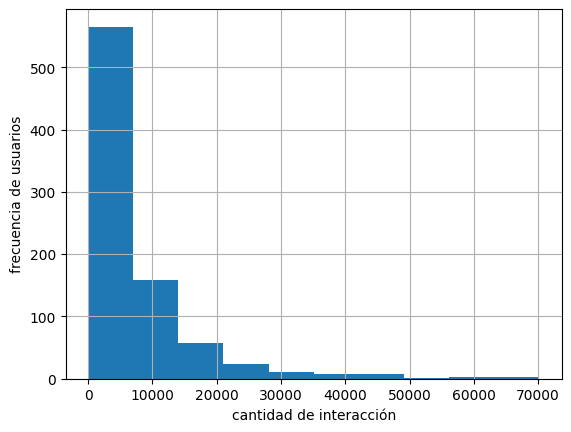

In [ ]:
import matplotlib.pyplot as plt

user_count['count'].hist()
plt.xlabel('cantidad de interacción')
plt.ylabel('frecuencia de usuarios')
plt.show()

Buscamos obtener un DataFrame con cada 'track-id' único y el número de veces que cada uno aparece en el DataFrame original, ordenado de mayor a menor por este recuento. La variable mt se asigna a este DataFrame resultante.

In [ ]:
# Esto lo usaremos para identificar las pistas más populares en el conjunto de datos, ya que las pistas con más usuarios únicos serían las más populares.
mt = df.groupby('track-id')['user-id'].agg({'count'}).sort_values(by='count', ascending=False)
mt

,count
track-id,
5a536521-64ae-4a57-8afa-2a4235bc8841,2028
24436eea-e79f-4592-b7f8-3e9bfe01f483,1841
6cbbb97d-2180-4ba9-97a8-6158b6332bb4,1802
ba4bcf45-fcdf-4ff7-a19e-be3fdffae337,1514
c741a7ef-dd33-4c79-a4d4-8745d9675620,1508
...,...
b41e4f70-c509-4952-b99d-5178f18f273a,1
b41e3f70a4a98b73,1
14694394-948a-4f88-92bd-5e3f9c8f6f69,1


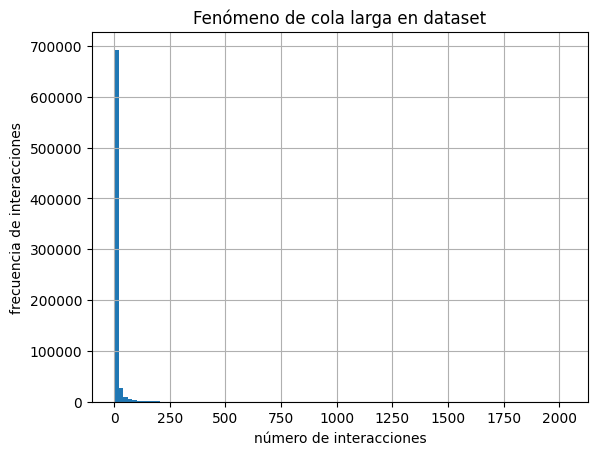

In [ ]:
#Fenómeno de cola larga por interacciones usuario tracks
mt['count'].hist(bins=100)
plt.xlabel('número de interacciones')
plt.ylabel('frecuencia de interacciones')
plt.title('Fenómeno de cola larga en dataset')
plt.show()

Nos quedamos solo con las columnas user-id y track-id a partir de las cuales construiremos nuestro sistema de recomendación.

In [ ]:
user_track = df[['user-id', 'track-id']]
user_track

,user-id,track-id
4127,user_000001,bd915801-db41-4b75-9b0a-94c34d1fa387
4128,user_000001,c948c97993787ca9
4129,user_000001,307307e5-aa4a-4de4-a96e-5a260fb3bb80
4130,user_000001,14f3f3b8-5750-4343-ab9b-30de8ed78ebb
4131,user_000001,0e42835d661524e7
...,...,...
19098848,user_001000,a490cabc-1e5c-4807-86c7-740c31a50009
19098849,user_001000,3e92e447-9e1f-440d-bc00-6734469880c5
19098850,user_001000,93d044e6-1bbb-46a6-ac8e-283382a89e6f
19098851,user_001000,5ac4386f-6146-4389-a762-4b43f362d2c8


In [ ]:
user_track.groupby('track-id')['track-id'].count().sort_values()

track-id
e4fa22a3-33f2-4adc-9842-ad324769de4c       1
7044d04d-59a6-4275-b444-7f7557e4c9cb       1
704486ab-3d98-497f-b15b-c3c3a9b450df       1
70445465-ec71-45de-afbf-3eda8f2325e3       1
70442294-1e5b-47e7-aef3-16d2979ab814       1
                                        ... 
c741a7ef-dd33-4c79-a4d4-8745d9675620    1508
ba4bcf45-fcdf-4ff7-a19e-be3fdffae337    1514
6cbbb97d-2180-4ba9-97a8-6158b6332bb4    1802
24436eea-e79f-4592-b7f8-3e9bfe01f483    1841
5a536521-64ae-4a57-8afa-2a4235bc8841    2028
Name: track-id, Length: 744370, dtype: int64

In [ ]:
user_track.groupby('track-id')['track-id'].count().sort_values().describe()

count    744370.000000
mean          7.686501
std          24.493910
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2028.000000
Name: track-id, dtype: float64

In [ ]:
user_track['track-id'].nunique()

744370

Evidenciamos muchas canciones que solo se han escuchado una vez. Ignoraremos estas canciones para reducir la dimensionalidad de la matriz de utilidad.

In [ ]:
track_counts = user_track['track-id'].value_counts()
threshold = 30 # tiene que haber sido escuchada al menos n veces

In [ ]:
user_track = user_track[user_track['track-id'].map(track_counts) >= threshold]

In [ ]:
user_track.groupby('track-id')['track-id'].count().sort_values()

track-id
805ac5ab-eafe-4520-8fb6-297eaf08f2d6      30
8ce79353-974f-44d4-beeb-d9e525e89421      30
0e511421-ee06-47df-ba0d-a58163fdf7a0      30
8d4f94d5-f46f-4e7a-9f73-45b8529f6ddd      30
8d5a39ea-7114-4758-8b65-e18f2fbe500d      30
                                        ... 
c741a7ef-dd33-4c79-a4d4-8745d9675620    1508
ba4bcf45-fcdf-4ff7-a19e-be3fdffae337    1514
6cbbb97d-2180-4ba9-97a8-6158b6332bb4    1802
24436eea-e79f-4592-b7f8-3e9bfe01f483    1841
5a536521-64ae-4a57-8afa-2a4235bc8841    2028
Name: track-id, Length: 36619, dtype: int64

In [ ]:
user_track['track-id'].value_counts().describe()

count    36619.000000
mean        78.154565
std         80.492762
min         30.000000
25%         38.000000
50%         52.000000
75%         85.000000
max       2028.000000
Name: track-id, dtype: float64

In [ ]:
user_track['track-id'].nunique()

36619

In [ ]:
user_track['count'] = user_track.groupby(['user-id', 'track-id'])['track-id'].transform('count')
user_track = user_track.drop_duplicates()
user_track

<ipython-input-36-60a63eda9ed5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_track['count'] = user_track.groupby(['user-id', 'track-id'])['track-id'].transform('count')


,user-id,track-id,count
4390,user_000001,919b8a05-e1eb-4402-a2a8-7cc40fcede7c,39
4391,user_000001,f59bfff4-1784-4ef6-84e5-75da053ba39a,30
4392,user_000001,e8db4e5c-0637-4b5f-841b-9a9449c85997,38
4393,user_000001,ead433ca-a4d6-462b-af46-afafe9b0f4ad,42
4419,user_000001,3e6d15da-59ca-4ac2-a8c8-54a6cdf388d4,2
...,...,...,...
19098662,user_001000,746b314e-dbcb-4393-b04f-813381b7e997,1
19098663,user_001000,cc14d998-bf97-4c94-a835-d4ed9717bc7a,1
19098716,user_001000,2a817be6-225c-48f9-bae2-df34b275172a,1
19098718,user_001000,0df79879-d8e4-478a-9b2c-9fa94243540b,1


In [ ]:
user_track.sort_values(by='count',ascending=False).head(20)

,user-id,track-id,count
18090924,user_000949,9eaa0926-93e4-4a82-a19e-ed8cb3f1ddbe,747
3084981,user_000155,5a536521-64ae-4a57-8afa-2a4235bc8841,664
6305827,user_000329,3dc07f41-89fb-41d6-8257-d156920eedc6,630
1717513,user_000084,5a536521-64ae-4a57-8afa-2a4235bc8841,611
6305853,user_000329,8f8f3cc7-902c-42c9-a5a1-ce3d08088b03,594
17442641,user_000906,4ac8f465-a2f2-4e95-be3f-b92cf51df658,588
6305836,user_000329,41eb90f4-7267-4858-8011-08def550f494,571
18091340,user_000949,4dd43868-8947-4228-9dd9-fa99bbbd49e9,568
5413812,user_000275,5f7ec3e4-0528-4b94-b4e5-87123166e9d1,430
3084969,user_000155,5114f297-ede6-4b89-bca5-0b97e8d1077d,418


Identificamos que había un usuario (user_000008) cuya actividad era anormal, puesto que había reproducido más de 15k canciones en un año lo cual no tiene mucho sentido práctco. Lo identificamos como outlier y lo eliminamos del dataset porque además no era representativo para la cantidad de datos que tenemos más sí dañaba la muestra.

In [ ]:
df = df[df['user-id']!='user_000008']
user_count = user_count[user_count['user-id']!='user_000008']
user_track = user_track[user_track['user-id']!='user_000008']

In [ ]:
user_track.sort_values(by='count',ascending=False).head()

,user-id,track-id,count
18090924,user_000949,9eaa0926-93e4-4a82-a19e-ed8cb3f1ddbe,747
3084981,user_000155,5a536521-64ae-4a57-8afa-2a4235bc8841,664
6305827,user_000329,3dc07f41-89fb-41d6-8257-d156920eedc6,630
1717513,user_000084,5a536521-64ae-4a57-8afa-2a4235bc8841,611
6305853,user_000329,8f8f3cc7-902c-42c9-a5a1-ce3d08088b03,594


In [ ]:
# Filtrar el df para incluir solo usuarios seleccionados previamente
user_track = user_track[user_track['user-id'].isin(selected_users)]
user_track.sort_values(by='count',ascending=False)
user_track.describe()

,count
count,25507.000000
mean,6.633630
std,14.671017
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,664.000000


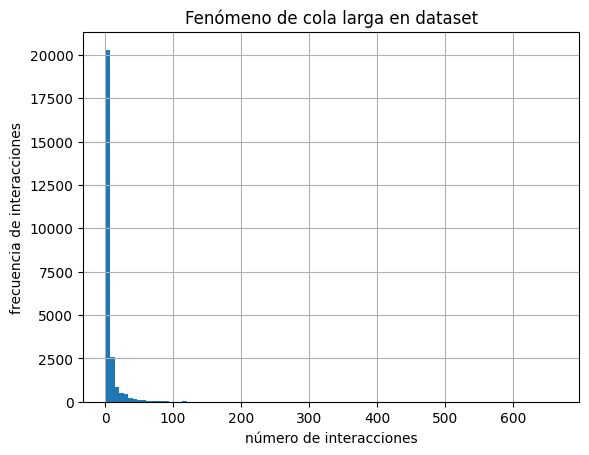

In [ ]:
user_track['count'].hist(bins=100)
plt.xlabel('número de interacciones')
plt.ylabel('frecuencia de interacciones')
plt.title('Fenómeno de cola larga en dataset')
plt.show()

### Calificación implícita basándonos en las interacciones

Primero, normalizamos las interacciones

In [ ]:
user_track['count_normalized'] = (user_track['count'] - user_track['count'].min()) / (user_track['count'].max() - user_track['count'].min())
user_track.describe()

,count,count_normalized
count,25507.000000,25507.000000
mean,6.633630,0.008497
std,14.671017,0.022128
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.001508
75%,6.000000,0.007541
max,664.000000,1.000000


Vamos a desarrollar un sistema de recomendación basado en clasificación numérica entre 1 y 5. Para ello, primero agruparemos los usuarios y para cada uno sacaremos los percentiles 20, 40, 60 y 80. Luego asignaremos la frecuencia de interaccion con un track al percentil que corresponda (1,2,3,4 o 5).

In [ ]:
def asignar_ranking(df, columna_frecuencia):
    # Calcula los percentiles 20, 40, 60, 80 para cada usuario
    percentiles = df.groupby('user-id')[columna_frecuencia].describe(percentiles=[.2, .4, .6, .8])
    percentiles = percentiles[['20%', '40%', '60%', '80%']].rename(columns={'20%': 'p20', '40%': 'p40', '60%': 'p60', '80%': 'p80'})

    # Inicializar columna de ranking
    df['ranking'] = 0

    # Asignar rankings basados en los percentiles
    for index, row in percentiles.iterrows():
        user_id = index
        p20, p40, p60, p80 = row['p20'], row['p40'], row['p60'], row['p80']

        # Asigna rankings de 1 a 5 basados en los percentiles de frecuencia
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] <= p20), 'ranking'] = 1
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p20) & (df[columna_frecuencia] <= p40), 'ranking'] = 2
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p40) & (df[columna_frecuencia] <= p60), 'ranking'] = 3
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p60) & (df[columna_frecuencia] <= p80), 'ranking'] = 4
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p80), 'ranking'] = 5

    return df

# Aplica la función al DataFrame 'user_track' y la columna 'count_normalized'
user_track_ranked = asignar_ranking(user_track, 'count_normalized')

In [ ]:
user_track.describe()

,count,count_normalized,ranking
count,25507.000000,25507.000000,25507.000000
mean,6.633630,0.008497,2.642882
std,14.671017,0.022128,1.527756
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,0.001508,2.000000
75%,6.000000,0.007541,4.000000
max,664.000000,1.000000,5.000000


Se puede observar la columna "ranking" con el nivel al que pertenece cada interacción usuario-item.

In [ ]:
user_track

,user-id,track-id,count,count_normalized,ranking
19571,user_000002,c0c761b3-a108-445c-ae73-98ed78ee2cf0,11,0.015083,5
19594,user_000002,6bf8dd88-a0fa-4d19-9bc5-ee0b765e22c1,19,0.027149,5
19597,user_000002,c45e44f5-9afb-44a7-8f91-64d9bf6e9261,5,0.006033,4
19599,user_000002,1c131fbf-a7e5-49f9-91b0-1539fc1177d6,5,0.006033,4
19600,user_000002,66746883-3854-425a-9bb0-d671e1283521,4,0.004525,4
...,...,...,...,...,...
18272649,user_000950,6c7fadb6-2cca-4a20-b8df-9994e7008cb2,13,0.018100,5
18272828,user_000950,7bcf8f24-38bb-4e27-87a8-8e036854f8cc,1,0.000000,1
18272873,user_000950,cae8bbec-c2ff-4972-9218-8f90acb07b1b,1,0.000000,1
18272987,user_000950,ac279edb-a46c-421f-8ca8-77f16e1ef283,1,0.000000,1


In [ ]:
# ver la cantidad de usuarios y items
num_users = user_track['user-id'].nunique()
num_items = user_track['track-id'].nunique()
print(f'número de usuarios = {num_users}, número de tracks = {num_items}')
print(22*16900)

número de usuarios = 27, número de tracks = 13867
371800


In [ ]:
user_track.describe()

,count,count_normalized,ranking
count,25507.000000,25507.000000,25507.000000
mean,6.633630,0.008497,2.642882
std,14.671017,0.022128,1.527756
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,0.001508,2.000000
75%,6.000000,0.007541,4.000000
max,664.000000,1.000000,5.000000


Este fragmento de código en Python utiliza la biblioteca Surprise para sistemas de recomendación. Primero, se crea un objeto Reader con una escala de calificación de 1 a 5. Luego, se carga el dataset desde un dataframe de pandas llamado user_track, que contiene las columnas 'user-id', 'track-id' y 'ranking'. El 'ranking' representa las calificaciones que asignamos previamente a los tracks por usuario. El resultado es un objeto Dataset de Surprise que se puede utilizar para entrenar un modelo de sistema de recomendación.

In [ ]:
reader = Reader(rating_scale = (1, 5))
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( user_track[ ['user-id', 'track-id', 'ranking'] ], reader )

## Experimentación

Vamos a probar variando la métrica de similitud entre Coseno y Pearson, que se encuentran en la librería Surprise. Además, utilizaremos los dos tipos de modelos colaborativos: basado en usuario y en item. Por último, experimentaremos con tres valores de k y tres valores de umbral.

Utilizando cross-validation con un valor de k=2 (número de pliegues), compararemos las métricas RMSE y MAE de los distintos modelos y seleccionaremos el mejor para hacer nuestro modelo de recomendación.

In [ ]:
print(f'Obtendremos {3*3*2} modelos con Coseno y {3*3*2} modelos con Pearson')

Obtendremos 18 modelos con Coseno y 18 modelos con Pearson


### Coseno

In [ ]:
from surprise.model_selection import cross_validate

# Valores de k y threshold para iterar
ks = [4, 8, 12]  # Ejemplo de valores de k
thresholds = [2, 4, 6]  # Ejemplo de valores de threshold

In [ ]:
# Iterar sobre todos los métodos de similitud, valores de k y user/item based
results = []
i = 1

similarity = 'cosine'
for user_based in [True, False]:  # True para user-based, False para item-based
    for k in ks:
        for min_support in thresholds:
            sim_options = {
                'name': similarity,
                'user_based': user_based,
                'min_support': min_support
            }
            model_name = f'user={user_based}, sim_method={similarity}, k={k}, threshold={min_support}'
            print(i, model_name)
            i+=1
            algo = KNNBasic(k=k, sim_options=sim_options)
            # Realizar validación cruzada y guardar los resultados
            # Se usa cross_validation
            cv_results = cross_validate(algo, surprise_dataset, measures=['RMSE', 'MAE'], cv=2, verbose=False)
            print('cv done')
            # Guardar los resultados con los parámetros utilizados
            results.append({
                'model_name': model_name,
                'similarity': similarity,
                'user_based': user_based,
                'k': k,
                'min_support': min_support,
                'rmse': cv_results['test_rmse'].mean(),

                'mae': cv_results['test_mae'].mean()
            })
            print(results[-1])
            print()

1 user=True, sim_method=cosine, k=4, threshold=2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=True, sim_method=cosine, k=4, threshold=2', 'similarity': 'cosine', 'user_based': True, 'k': 4, 'min_support': 2, 'rmse': 1.7596402332024064, 'mae': 1.4765144933955203}

2 user=True, sim_method=cosine, k=4, threshold=4
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=True, sim_method=cosine, k=4, threshold=4', 'similarity': 'cosine', 'user_based': True, 'k': 4, 'min_support': 4, 'rmse': 1.7558942263222008, 'mae': 1.4748728855300426}

3 user=True, sim_method=cosine, k=4, threshold=6
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

10 user=False, sim_method=cosine, k=4, threshold=2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=cosine, k=4, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 4, 'min_support': 2, 'rmse': 1.566076035654027, 'mae': 1.4238594281559753}


13 user=False, sim_method=cosine, k=8, threshold=2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=cosine, k=8, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 8, 'min_support': 2, 'rmse': 1.565440006647099, 'mae': 1.424497954736243}


16 user=False, sim_method=cosine, k=12, threshold=2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=cosine, k=12, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 12, 'min_support': 2, 'rmse': 1.5664152017049005, 'mae': 1.4253633265408503}



### Pearson

In [ ]:
# Iterar sobre todos los métodos de similitud, valores de k y user/item based
results = []
i = 1

similarity = 'pearson'
for user_based in [True, False]:  # True para user-based, False para item-based
    for k in ks:
        for min_support in thresholds:
            sim_options = {
                'name': similarity,
                'user_based': user_based,
                'min_support': min_support
            }
            model_name = f'user={user_based}, sim_method={similarity}, k={k}, threshold={min_support}'
            print(i, model_name)
            i+=1
            algo = KNNBasic(k=k, sim_options=sim_options)
            # Realizar validación cruzada y guardar los resultados
            # Se usa cross_validation
            cv_results = cross_validate(algo, surprise_dataset, measures=['RMSE', 'MAE'], cv=2, verbose=False)
            print('cv done')
            # Guardar los resultados con los parámetros utilizados
            results.append({
                'model_name': model_name,
                'similarity': similarity,
                'user_based': user_based,
                'k': k,
                'min_support': min_support,
                'rmse': cv_results['test_rmse'].mean(),
                'mae': cv_results['test_mae'].mean()
            })
            print(results[-1])
            print()

1 user=True, sim_method=pearson, k=4, threshold=2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=True, sim_method=pearson, k=4, threshold=2', 'similarity': 'pearson', 'user_based': True, 'k': 4, 'min_support': 2, 'rmse': 1.7119455706184505, 'mae': 1.4481591146458803}

2 user=True, sim_method=pearson, k=4, threshold=4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=True, sim_method=pearson, k=4, threshold=4', 'similarity': 'pearson', 'user_based': True, 'k': 4, 'min_support': 4, 'rmse': 1.6968743350912217, 'mae': 1.443028645021943}

3 user=True, sim_method=pearson, k=4, threshold=6
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simila

13 user=False, sim_method=pearson, k=8, threshold=2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=pearson, k=8, threshold=2', 'similarity': 'pearson', 'user_based': False, 'k': 8, 'min_support': 2, 'rmse': 1.5711759451986893, 'mae': 1.4298265720888699}

16 user=False, sim_method=pearson, k=12, threshold=2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=pearson, k=12, threshold=2', 'similarity': 'pearson', 'user_based': False, 'k': 12, 'min_support': 2, 'rmse': 1.5708668892285091, 'mae': 1.428253970218262}


Todos los mejores modelos son item-item.

## Selección del modelo

Después de comparar los mejores modelos, tomamos la decisión de optar por el modelo con las siguientes características

13 user=False, sim_method=cosine, k=8, threshold=2

{'model_name': 'user=False, sim_method=cosine, k=8, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 8, 'min_support': 2, 'rmse': 1.565440006647099, 'mae': 1.424497954736243}

In [ ]:
print('llega')

llega


In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': False,
    'min_support': 2
}
model = KNNBasic(k=8, sim_options=sim_options)

Dividimos el dataset en un conjunto de entrenamiento y un conjunto de prueba con una proporción 80-20.

In [ ]:
train_set, test_set = train_test_split(surprise_dataset, test_size=.2)

30.000 interacciones falla

15.000 funciona

Estimo máximo 22.000

In [ ]:
#Se le pasa la matriz de utilidad al algoritmo
model.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
test_predictions=model.test(test_set)

In [ ]:
random.sample(test_predictions, 20)

[Prediction(uid='user_000002', iid='c837f888-d471-4b07-bcbc-1b9f7406ec1a', r_ui=1.0, est=2.6431266846361186, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid='user_000411', iid='dc494e7e-ea2c-42e4-8661-d17a71f1d178', r_ui=1.0, est=2.6431266846361186, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='user_000002', iid='58b187dd-e587-4cfe-9cbd-450b07ecbe05', r_ui=1.0, est=2.6431266846361186, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='user_000871', iid='3a68ebd1-af3d-482f-b9d2-147a3a5f2470', r_ui=4.0, est=3.4982213696688556, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid='user_000458', iid='82498850-299b-4bda-a70a-20a087b09db1', r_ui=3.0, est=2.6431266846361186, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='user_000871', iid='1168c3ce-d045-4f33-bf10-7341369135b1', r_ui=4.0, est=2.643126684636

In [ ]:
accuracy.rmse(test_predictions)

RMSE: 1.5304


1.5303627325664

### Exportación del modelo

In [ ]:
from surprise.dump import dump, load
dump('/content/drive/MyDrive/Colab files/model', algo=model)

In [ ]:
import gc
import ctypes

# borrar cache
libc = ctypes.CDLL("libc.so.6")
libc.malloc_trim(0)

gc.collect()

27

## Exportación de datos para el backend

### Tabla user

In [ ]:
!pip install faker
!pip install unidecode

In [ ]:
from faker import Faker
from unidecode import unidecode
import random
import uuid

# Instanciar Faker
fake = Faker(['es_CO', 'es_CL'])

# Seleccionar los usuarios unicos de user_track que aparezcan en df_user. Tomar las filas de estos usuarios en df_user
tabla_user = df_user[df_user['#id'].isin(user_track['user-id'].unique())]
# Crear columna con nombre de usuario
tabla_user['nombre'] = tabla_user['#id'].apply(lambda x: unidecode(fake.name()))
tabla_user.rename(columns={'#id':'user-id'}, inplace=True)
tabla_user['user-id'] = [str(uuid.uuid4()) for _ in range(len(tabla_user))]

tabla_user

<ipython-input-63-2230bcc9266c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabla_user['nombre'] = tabla_user['#id'].apply(lambda x: unidecode(fake.name()))
<ipython-input-63-2230bcc9266c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabla_user.rename(columns={'#id':'user-id'}, inplace=True)
<ipython-input-63-2230bcc9266c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,user-id,gender,age,country,registered,nombre
1,29fa7303-3f22-40ad-9455-cb70f4a35e76,f,NaN,Peru,"Feb 24, 2006",Claudia Katherine Novoa Contreras
83,f6f884d8-72f7-4960-b43c-e78d0a771d0a,m,18.0,Venezuela,"Dec 4, 2005",Johana Hernandez Ramirez
133,ef85ce57-2c35-4336-8dd4-21f602b5ca80,m,30.0,Chile,"Oct 17, 2005",Jesus Alexis Olmos Riveros
136,a4053ae6-223c-4635-91ab-2928afcd1ec1,m,19.0,Chile,"Dec 1, 2006",Rene Jose Contreras Armijo
154,5c44a01e-0d4e-4e16-95ca-6bb45ba7e47f,m,NaN,Venezuela,"Jul 11, 2006",Juan Fernando Rojas Sanchez
192,98f5e64e-6daf-46e0-bb95-b87a63e50dfb,m,30.0,Peru,"Oct 27, 2005",Eliana Jazmin Martinez Arrieta
251,0ab7a888-0aa3-41fb-800a-1e5ba6694433,m,31.0,Argentina,"Aug 25, 2004",Emma Lagos Labra
295,02a1d056-560e-4729-8283-1df4f1e90d68,m,28.0,Argentina,"Jan 26, 2005",Sonia Elisa Vergara
339,2a3b3853-51cd-46f6-af92-7b42079d880d,NaN,NaN,Venezuela,"Aug 7, 2006",Marco Parada Galdames
352,6de2ae5b-3a9e-4430-84ce-1189861841f8,m,29.0,Argentina,"Jun 2, 2006",Amparo Bejarano


In [ ]:
drive_path = os.path.join('drive', 'MyDrive', 'Colab files')
tabla_user.to_csv(os.path.join(drive_path,'tabla_user.csv'), index=False)

### Tabla tracks

In [ ]:
user_track['track-id'] = user_track['track-id'].astype(str)
df['track-id'] = df['track-id'].astype(str)

tabla_track = user_track.groupby('track-id')['track-id'].agg({'count'}).sort_values(by='count', ascending=False).reset_index()

tabla_track = pd.merge(tabla_track, df[['track-id','track-name','artist-id']], on='track-id', how='left').drop_duplicates(['track-id'])
tabla_track

,track-id,count,track-name,artist-id
0,a9fb5fe9-28ab-4a5e-800f-7cec7e0fafd7,12,Say It Right,13655113-cd16-4b43-9dca-cadbbf26ee05
368,38de8a8d-954b-485d-b1fc-ec8b485ac85e,12,November Rain,eeb1195b-f213-4ce1-b28c-8565211f8e43
674,c7391374-91be-4919-b913-7bc8c2cb418b,12,Smells Like Teen Spirit,85af0709-95db-4fbc-801a-120e9f4766d0
1287,49888c84-b4f7-491e-a93c-40c6c0393c19,11,Paranoid Android,a74b1b7f-71a5-4011-9441-d0b5e4122711
2059,3c2347fd-98f7-4dec-9484-059e727db480,11,Maneater,13655113-cd16-4b43-9dca-cadbbf26ee05
...,...,...,...,...
1504664,6da5d6da-5eec-4e57-9f16-fcf3d01929e6,1,Wax Simulacra,20883363-1ea4-4d72-ad72-c0e767038f3e
1504785,6da73869-423e-47f4-8270-0c46cb01aa00,1,Six Barrel Shotgun,32b90c92-9978-4a07-90eb-caa4b22f4907
1504942,6da93f51-6a63-435d-a3a9-10974b2eed97,1,The Warmth,e3e0abcd-7671-4482-a9d8-462f5acc9be5
1505031,6dabf560-b65c-4dda-a4b5-a1db3f5dc15a,1,Thrash Unreal,a66ebddc-ff04-46b8-820a-15c63e80dba1


In [ ]:
tabla_track.to_csv(os.path.join(drive_path,'tabla_track.csv'), index=False)

### Tabla artistas

In [ ]:
tabla_artist = pd.merge(tabla_track['artist-id'].drop_duplicates(), df[['artist-id','artist-name']], on='artist-id', how='left').drop_duplicates(['artist-id'])
tabla_artist

,artist-id,artist-name
0,13655113-cd16-4b43-9dca-cadbbf26ee05,Nelly Furtado
3503,eeb1195b-f213-4ce1-b28c-8565211f8e43,Guns N' Roses
12083,85af0709-95db-4fbc-801a-120e9f4766d0,Nirvana
12696,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead
50334,95e1ead9-4d31-4808-a7ac-32c3614c116b,The Killers
...,...,...
3146967,5d0c202c-e30f-40c4-abf5-c0007af0d1cc,Chris Clark
3147604,b5fb0f1a-2cd4-4759-9d80-648643f70c43,シートベルツ
3147838,b0db1836-68e8-4fa4-93f7-f19ea5fce809,The Broken West
3148056,e5f2a453-68b5-48b0-85c4-9ec317dee0b0,Hood


In [ ]:
tabla_artist.to_csv(os.path.join(drive_path,'tabla_artist.csv'), index=False)